Primero voy a simular los datos y graficarlos:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson


def poisson_pmf(k, lamb):
    return poisson.pmf(k, lamb)

valores_tiempo = np.array([4.21,3.29,12.09,12.83,7.70,6.96,3.68,18.93,9.66,9.35]) #en seg

conteos_por_intervalo = np.array([5,3,5,8,7,5,5,7,5,3,11,4,13,7,10,4,2,8,11,3,8,5,4,4,3,5,5,7,4,6]) 

# Histograma: frecuencias absolutas
valores, frecuencias = np.unique(conteos_por_intervalo, return_counts=True)

# Normalizamos para obtener probabilidades
frecuencias = frecuencias / np.sum(frecuencias)

mej_val, cov = curve_fit(poisson_pmf, valores, frecuencias, p0=[valores_tiempo.mean()]) 
print('mej_val: {}'.format(mej_val))
print(cov)

bin_edges = np.arange(np.min(conteos_por_intervalo),np.max(conteos_por_intervalo)+1)
observed, _ = np.histogram(conteos_por_intervalo, bins=bin_edges)

# Calcular frecuencias esperadas usando la distribución exponencial negativa acumulada
cdf_values = poisson.cdf(bin_edges, mej_val[0])
expected = np.diff(cdf_values) * len(conteos_por_intervalo)
# Normalizar esperados
expected = expected * (observed.sum() / expected.sum())

def chi_sqr(dathistexp,dathistaj):
    return sum(((dathistexp-dathistaj)**2)/(dathistaj))

print('Chi cuadrado =',chi_sqr(observed,expected))

mej_val: [5.31510156]
[[0.31358707]]
Chi cuadrado = 41.75755462522169


Tasa de eventos (lambda): 8.87


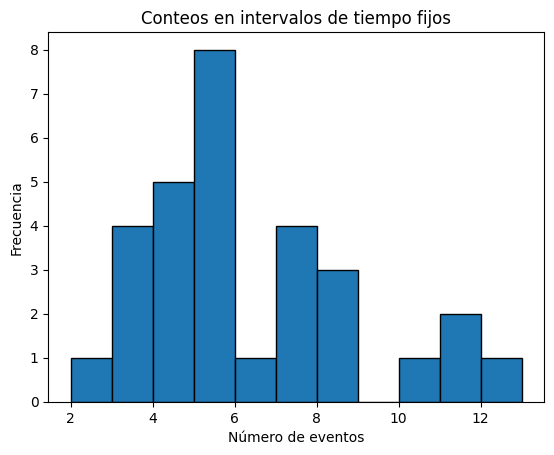

In [6]:
import numpy as np
import matplotlib.pyplot as plt


valores_tiempo = np.array([4.21,3.29,12.09,12.83,7.70,6.96,3.68,18.93,9.66,9.35]) #en seg

conteos_por_intervalo = np.array([5,3,5,8,7,5,5,7,5,3,11,4,13,7,10,4,2,8,11,3,8,5,4,4,3,5,5,7,4,6]) 

#americio-241
conteos_americio = np.array([1,8,6,2,1,8,6,11,3,4,2,3,3,6,7,6,9,5,5,2,2,4,4,4,5,9,9,4,4,2])

#torio - barra soldadura
conteos_torio = np.array([3,2,0,7,2,5,6,5,11,4,4,2,5,6,4,2,6,0,1,4,8,1,6,6,6,2,7,2,5,4])

lambda_rate = valores_tiempo.mean()  # eventos por segundo

print("Tasa de eventos (lambda):", lambda_rate)

plt.hist(conteos_por_intervalo, bins=range(min(conteos_por_intervalo), max(conteos_por_intervalo)+1), edgecolor='black')
plt.title("Conteos en intervalos de tiempo fijos")
plt.xlabel("Número de eventos")
plt.ylabel("Frecuencia")
plt.show()

Con curve_fit:

λ ajustada = 5.315


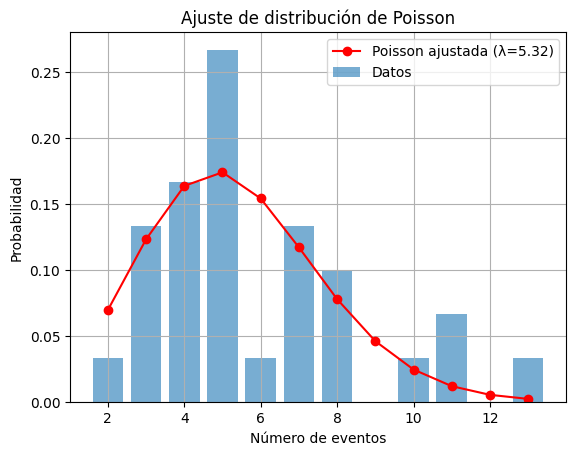

Media del ajuste: 5.32
Varianza del ajuste: 5.32
Desviación estándar del ajuste: 2.3


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson



# Histograma: frecuencias absolutas
valores, frecuencias = np.unique(conteos_por_intervalo, return_counts=True)

# Normalizamos para obtener probabilidades
frecuencias = frecuencias / np.sum(frecuencias)

# Definimos la función de Poisson a ajustar
def poisson_pmf(k, lamb):
    return poisson.pmf(k, lamb)

# Ajuste con curve_fit
# A veces hay que poner el valor inicial de lambda, por ejemplo: p0=[1.0] o un valor aproximado del lambda (parámetro), para que no de error
params_opt, params_cov = curve_fit(poisson_pmf, valores, frecuencias, p0=[valores_tiempo.mean()]) 

# Resultado del ajuste
lambda_ajustada = params_opt[0]
print(f"λ ajustada = {lambda_ajustada:.3f}")

# Graficamos
x = np.arange(min(valores), max(valores)+1)
plt.bar(valores, frecuencias, alpha=0.6, label='Datos')
plt.plot(x, poisson_pmf(x, lambda_ajustada), 'o-', color='red', label=f'Poisson ajustada (λ={lambda_ajustada:.2f})')

plt.xlabel("Número de eventos")
plt.ylabel("Probabilidad")
plt.title("Ajuste de distribución de Poisson")
plt.legend()
plt.grid()
plt.show()

print(f'Media del ajuste: {lambda_ajustada:.2f}')
print(f'Varianza del ajuste: {lambda_ajustada:.2f}')
print(f'Desviación estándar del ajuste: {np.sqrt(lambda_ajustada):.1f}')

Luego con la que arroja curve_fit

[1 4 5 8 1 4 3 0 1 2 1]
30 26.947968554962436


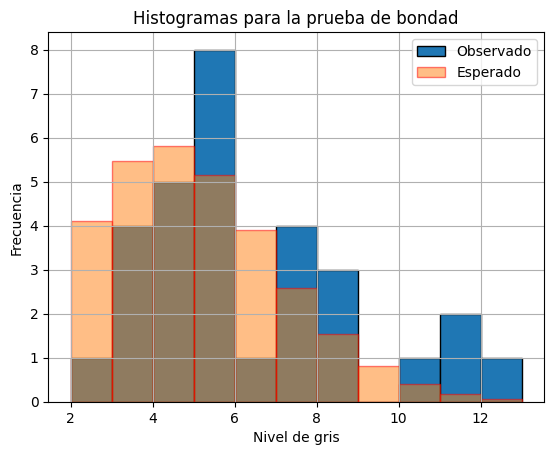

media = 5.32
El valor de chi2 es 41.76 y el valor p es 0.0 %. El número de intervalos es 11


In [24]:
from scipy.stats import poisson, chisquare

def pruebaBondad(datos):
        mu = lambda_ajustada
        
        bin_edges = np.arange(np.min(datos), np.max(datos)+1)


        # Paso 2: calcular observados y esperados
        observed, _ = np.histogram(datos, bins=bin_edges)
        print(observed)
        # Calcular frecuencias esperadas usando la distribución exponencial negativa acumulada
        cdf_values = poisson.cdf(bin_edges, mu)
        expected = np.diff(cdf_values) * len(datos)
        print(len(datos), expected.sum())
        
        # Normalizar esperados
        
        expected = expected * (observed.sum() / expected.sum())
        
     
        # Calcular las posiciones centrales de los bins
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Graficar
        plt.bar(bin_centers, observed, width=np.diff(bin_edges), edgecolor='black',label='Observado')
        plt.bar(bin_centers, expected, width=np.diff(bin_edges), edgecolor='red',alpha=0.5,label='Esperado')
        plt.xlabel("Nivel de gris")
        plt.ylabel("Frecuencia")
        plt.title("Histogramas para la prueba de bondad")
        plt.grid(True)
        plt.legend()
        plt.show()

        # Paso 3: aplicar prueba chi-cuadrado
        chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

        print('media = {:.2f}'.format(mu))
        print('El valor de chi2 es {:.2f} y el valor p es {:.1f} %. El número de intervalos es {}'.format(chi2_stat, 100*p_value,len(bin_edges)-1))
pruebaBondad(conteos_por_intervalo)

Repetir esto con los datos arrojados con las muestras no es difícil, solo cambiar los valores de conteos y sale.

In [ ]:
from scipy.stats import poisson, chisquare



def pruebaBondad(datos):
        image = datos
        mu = image.mean()
        bin_edges = bins=np.arange(min(datos)-2, max(datos)+1, 4)

       

        # Paso 2: calcular observados y esperados
        observed, _ = np.histogram(image, bins=bin_edges)

        # Calcular frecuencias esperadas usando la distribución exponencial negativa acumulada
        cdf_values = poisson.cdf(bin_edges, mu)
        expected = np.diff(cdf_values) * len(image)
        # Normalizar esperados
        expected = expected * (observed.sum() / expected.sum())

        # Calcular las posiciones centrales de los bins
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Graficar
        plt.bar(bin_centers, observed, width=np.diff(bin_edges), edgecolor='black',label='Observado')
        plt.bar(bin_centers, expected, width=np.diff(bin_edges), edgecolor='red',alpha=0.5,label='Esperado')
        plt.xlabel("Nivel de gris")
        plt.ylabel("Frecuencia")
        plt.title("Histogramas para la prueba de bondad")
        plt.grid(True)
        plt.legend()
        plt.show()

        # Paso 3: aplicar prueba chi-cuadrado
        chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

        print('media = {:.2f}'.format(mu))
        print('El valor de chi2 es {:.2f} y el valor p es {:.1f} %. El número de intervalos es {}'.format(chi2_stat, 100*p_value,bins))
pruebaBondad(conteos_por_intervalo)